# Project 2: Word Embeddings and the Brain

## Structured Task - Sentence decoding

### Part 1
Let's observe the results from Homework Assignment 3, question 3 that were obtained with GloVe.

In [1]:
# Download and extract the data and learn_decoder.py
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip -o files.zip
!rm files.zip

--2023-07-01 07:19:37--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 74.125.126.139, 74.125.126.113, 74.125.126.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.126.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1jpp57nujq289skkfhjbibvovoep8950/1688195925000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=fc5651ab-50ce-4aed-8ac2-70e70cd9654e [following]
--2023-07-01 07:19:38--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1jpp57nujq289skkfhjbibvovoep8950/1688195925000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=fc5651ab-50ce-4aed-8ac2-70e70cd9654e
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleusercontent.com)... 142.251.6.132, 2

In [2]:
# Let's load the functions from learn_decoder.py
from learn_decoder import *

# and the data
data = read_matrix("imaging_data.csv", sep=",")
vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

In [3]:
import numpy as np
from collections import defaultdict


# Calculate cosine similarity
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    similarity = dot_product / (norm_x * norm_y)
    return similarity


# Calculate the rank of a vector
def calculate_rank(index, target_vec, vectors):
  vectors_dict = defaultdict(None)
  for row in range(vectors.shape[0]):
    vectors_dict[row] = cosine_similarity(target_vec, vectors[row, :])
  vectors_dict = {k: v for k, v in sorted(vectors_dict.items(), key=lambda item: item[1], reverse=True)}
  for rank, key in enumerate(vectors_dict.keys(), start=1):
      if key == index:
          return rank

# Number of folds
k = 18

# Calculate the number of concepts per fold
concepts_per_fold = len(concepts) // k

# Splitting the data a into training and test sets according to 18-
# fold cross-validation
average_ranks = []
start = 0
end = concepts_per_fold
for i in range(0,k):
  test_vectors = vectors[start:end]
  test_data = data[start:end]
  test_list = list(range(start,end))
  train_list = list(set(range(180)) - set(test_list))

  # Train the decoder using the provided code
  decoder = learn_decoder(data[train_list, :],vectors[train_list, :])
  start+=concepts_per_fold
  end+=concepts_per_fold

  # Use the decoder to decode semantic vectors
  prediction = np.dot(test_data,decoder)

  #evaluate the accuracy of these decoded vectors
  ranks = []
  for v , index in enumerate(test_list):
    ranks.append(calculate_rank(index, prediction[v], vectors))

  average_ranks.append(np.mean(ranks))

# Print the average rank for each fold
# for i, rank in enumerate(average_ranks):
#     print("Fold {}: Average Rank = {}".format(i+1, rank))
average_ranks_HW3 =average_ranks



Now let's plot the averaged accuracy score for each fold  

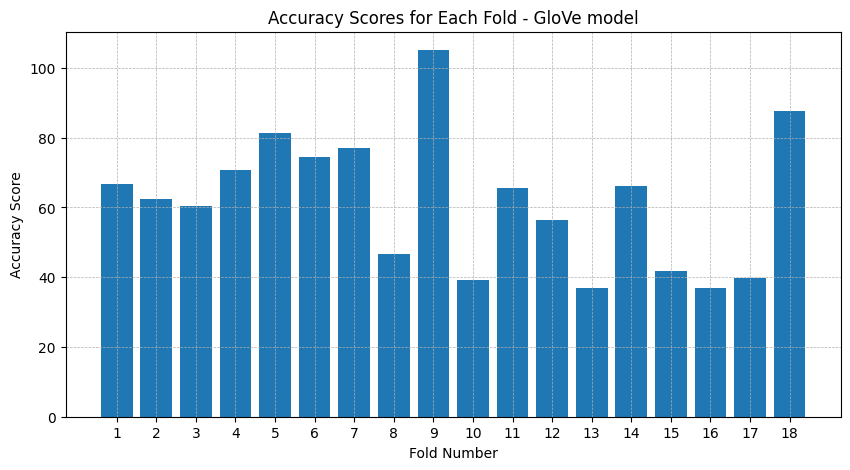

Mean:  61.911
Standard Deviation:  18.786


In [4]:
#TODO
import matplotlib.pyplot as plt

# Plotting the accuracy scores
fold_numbers = range(1, k+1)
plt.figure(figsize=(10,5))
plt.bar(fold_numbers, average_ranks)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Each Fold - GloVe model')
plt.xticks(fold_numbers, map(int, fold_numbers))  # Set x-axis labels as integers
plt.grid(True, linestyle='dashed', linewidth = 0.5)
plt.show()

# The mean of the accuracies:
print("Mean: ", round(np.mean(average_ranks),3))
std = np.std(average_ranks)
print("Standard Deviation: ", round(std, 3))


Now, let's perform the analysis of Homework Assignment 3, question 3 using  Word2vec and comparing the results to those we obtained before with GloVe.

In [5]:
import numpy as np
from learn_decoder import *
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
from gensim.models import Word2Vec
import gensim.downloader as api

warnings.filterwarnings(action = 'ignore')
data = read_matrix("imaging_data.csv", sep=",")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts
# word2vec_path = "/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin"
# model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
#  takes a list of concepts as input and returns a matrix of vectors corresponding to those concepts.

def create_vectors(concepts):
  word2vec=[]
  concepts=list(concepts)
  concepts = [str(value) for value in concepts]
  keys = model.key_to_index
  vectors_matrix = np.zeros((180,300), dtype=np.float32)
  for i,c in enumerate(concepts):
    if c in keys: # argumentatively is the only word that not in keys, index 6
      vectors_matrix[i] = model.get_vector(c)

  vectors_matrix[6] = vectors_matrix[5]
  return vectors_matrix

vectors=create_vectors(concepts)

In [7]:
# calculates the cosine similarity between two input vectors x and y

def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
  numerator=np.dot(x,y)
  denominator= np.linalg.norm(x)*np.linalg.norm(y)
  return numerator/denominator

In [8]:
#  ranks the similarity between a given semantic_vec and a list of vectors based on cosine similarity

def rank_based_acc(semantic_vec,vectors,index_target):
  dic={}
  for index,vec in enumerate(vectors):
    dic[index]=cosine_similarity(vec,semantic_vec)

  values_by_similarity = sorted(dic.items(), key=lambda x: x[1],reverse=True)
  for location,value in enumerate(values_by_similarity):
    if index_target==value[0]:
      return location


index=0
avg_ranks_by_folds={}
for i in range(0,180,10):
  # print(i)
  M = learn_decoder(np.concatenate((data[:i], data[i+10:])),np.concatenate((vectors[:i], vectors[i+10:])))
  data_test_vectors=data[i:i+10]
  fold_semantic_vectors=np.dot(data_test_vectors,M)
  rank=0
  for vector in fold_semantic_vectors:
    rank+=rank_based_acc(vector,vectors,index)
    index+=1
  avg_ranks_by_folds[i+10]=rank/10

### word2vector results:

mean:
59.922
std:
11.423


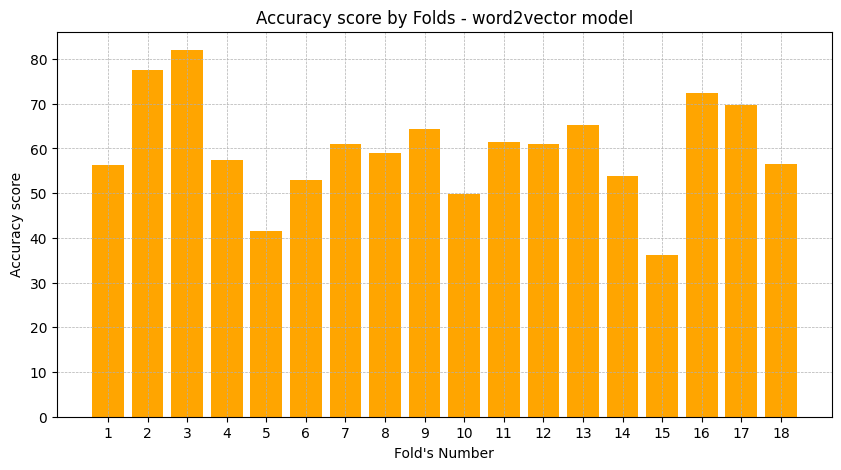

In [9]:
import matplotlib.pyplot as plt
import statistics
import numpy as np

k = 18

x = np.arange(1, k+1)
y = list(avg_ranks_by_folds.values())

print("mean:")
print(round(statistics.mean(y),3))
print("std:")
std = round(statistics.stdev(y),3)
print(std)
# Plotting the graph
plt.figure(figsize=(10,5))
plt.bar(x, y, color="orange")
plt.xlabel("Fold's Number")
plt.ylabel('Accuracy score')
plt.title('Accuracy score by Folds - word2vector model')
plt.xticks(range(1, 19))
plt.grid(True, linestyle='dashed', linewidth = 0.5)
plt.show()



### Comparing the models

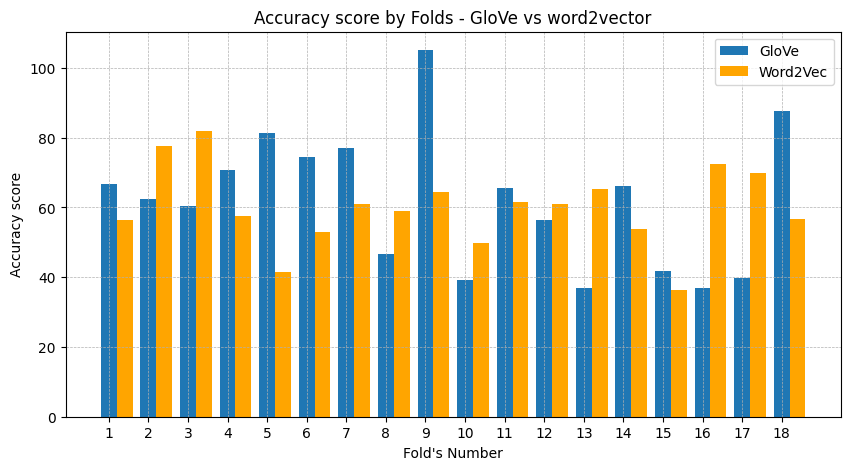

In [10]:
# Plotting comparison graph

# Data for the first bar graph
k = 18
fold_numbers = range(1, k+1)
average_ranks = average_ranks

# Data for the second bar graph
x = np.arange(1, k+1)
y = list(avg_ranks_by_folds.values())

# Set the width of each bar
bar_width = 0.4

# Plotting the bar graphs
plt.figure(figsize=(10,5))
plt.bar(fold_numbers, average_ranks, label='GloVe', width=bar_width)
plt.bar(x+ bar_width, y, color="orange", label='Word2Vec', width=bar_width)
plt.xlabel("Fold's Number")
plt.ylabel('Accuracy score')
plt.title('Accuracy score by Folds - GloVe vs word2vector')
plt.xticks(range(1, k+1))
plt.grid(True, linestyle='dashed', linewidth = 0.5)
plt.legend(loc='upper right')

# Adjusting subplot spacing
plt.subplots_adjust(wspace=0.5)

# Display the combined plot
plt.show()

In [11]:
# Calculating mean and standard deviation
mean_1 = round(np.mean(average_ranks), 3)
std_1 = round(np.std(average_ranks), 3)
mean_2 = round(np.mean(y), 3)
std_2 = round(np.std(y), 3)

print(f"GloVe mean score is: {mean_1}")
print(f"Word2Vec mean score is: {std_1}")
print()
print(f"GloVe std score is: {mean_2}")
print(f"Word2Vec mean score is: {std_2}")

GloVe mean score is: 61.911
Word2Vec mean score is: 18.786

GloVe std score is: 59.922
Word2Vec mean score is: 11.101


### Conclusions:

We can see that in some of the folds there are significant changes, such as folds 2,3,16 and especially 9, but even though,  it is clear that the average value is maintained: 59.922 in word2vec model comparing to the one in GloVe: 61.911. In addition, the standard deviation in GloVe is even higher: 18.786 comparing to 11.423 in our new model.

### Part 2
The similarities and differences between analyzes 1, 2, and 3 in Pereira et al., 2018:

Similarities:
1. In all three analyses, semantic information is decoded using a decoder that has been trained on brain activation patterns.
2. The decoders in all three analyzes use ridge regression for predicting each dimension of the semantic vectors.
3. Participants in various experiments provided the brain imaging data used to train the decoders.
4. The decoders were evaluated using cross-validation techniques
5. Pairwise classification tasks and rank accuracy classification tasks were used to evaluate the decoders' performance.

Differences:
1. Analysis 1 focuses on single concept decoding using three different paradigms: sentences, pictures, and word clouds. The decoding performance is evaluated separately for each paradigm, as well as for the average of the three paradigms. Analyzes 2 and 3, on the other hand, involve sentence decoding using independent sets of stimuli in two separate experiments.
2. Analysis 1 evaluates decoding performance by comparing decoded vectors to text-derived semantic vectors, whereas Analyzes 2 and 3 evaluate performance by distinguishing sentences at different levels of granularity.
3. While Analyzes 2 and 3 each have 8 and 6 participants, Analysis 1 has more - 16 participants.
4. In Analysis 1 they trained the decoder and evaluated its ability to generate concepts from provided brain data, whereas in experiments 2 and 3 they used a decoder that had already been trained on specific concepts and tested if it could decode brain-data for sentences.
5. The only significant differences between experiments 2 and 3 are the actual stimuli used and the addition of a narrative passage as a stimulus. However, experiment 1 is different from 2 and 3 in that it used single words as the stimulus rather than passages.

### Part 3


#### Testing the GloVe based decoder model we trained in Homework Assignment 3 question 3 on the datasets from analyses 2 & 3.

Lets read Datasets EXP2 (Analysis 2) and EXP3 (Analysis 3) according our guidelines

In [12]:
!pip install gdown
from google.colab import drive
drive.mount('/content/gdrive')
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip
!gdown --folder https://drive.google.com/drive/folders/1gFIrqTvvi6wsowcN3U2iZiVDvEC3fuxq
!mv -v "sample_data"/* ./

Mounted at /content/gdrive
--2023-07-01 07:39:06--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 74.125.126.101, 74.125.126.100, 74.125.126.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.126.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3g2l9mf9cabgab1o1koovouclkak7dp1/1688197125000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=f30245ec-ad27-4a79-96da-dd5929081270 [following]
--2023-07-01 07:39:06--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3g2l9mf9cabgab1o1koovouclkak7dp1/1688197125000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=f30245ec-ad27-4a79-96da-dd5929081270
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleuserconte

In [13]:
import pickle

file_path = '/content/Structured Task (sentence decoding)/EXP2.pkl'  # Path to the EXP2 file
with open(file_path, 'rb') as exp2:
    exp2_dict = pickle.load(exp2)

file_path = '/content/Structured Task (sentence decoding)/EXP3.pkl'  # Path to the EXP3 file
with open(file_path, 'rb') as exp3:
    exp3_dict = pickle.load(exp3)

#### Experiment 2

In [14]:
# Load Fmridata from exp2_dict
exp2_data = exp2_dict.get("Fmridata")

# Read vectors from file
exp2_vectors_file = "vectors_384sentences.GV42B300.average.txt"
exp2_vectors = read_matrix("/content/Structured Task (sentence decoding)/vectors_384sentences.GV42B300.average.txt", sep=" ")

# Read sentences from file
exp2_sentences_file = "/content/Structured Task (sentence decoding)/stimuli_384sentences.txt"
with open(exp2_sentences_file, "r") as exp2_sentences:
    exp2_concepts = np.asarray(exp2_sentences.readlines())

In [102]:
# Number of folds
k = 18

# Calculate the number of concepts per fold
concepts_per_fold = len(exp2_concepts) // k

# Splitting the data into training and test sets according to 18-fold cross-validation
exp2_average_ranks = []
start = 0
end = concepts_per_fold
for i in range(k):
    test_vectors = exp2_vectors[start:end]
    test_data = exp2_data[start:end]
    test_list = list(range(start, end))
    train_list = list(set(range(len(exp2_data))) - set(test_list))

    # Train the decoder using the provided code
    decoder2 = learn_decoder(exp2_data[train_list, :], exp2_vectors[train_list, :])

    start += concepts_per_fold
    end += concepts_per_fold

    # Use the decoder to decode semantic vectors
    prediction2 = np.dot(test_data, decoder2)

    # Evaluate the accuracy of these decoded vectors
    ranks = []
    for v, index in enumerate(test_list):
        ranks.append(calculate_rank(index, prediction2[v], exp2_vectors))

    exp2_average_ranks.append(np.mean(ranks))

mean:
132.775
std:
20.298


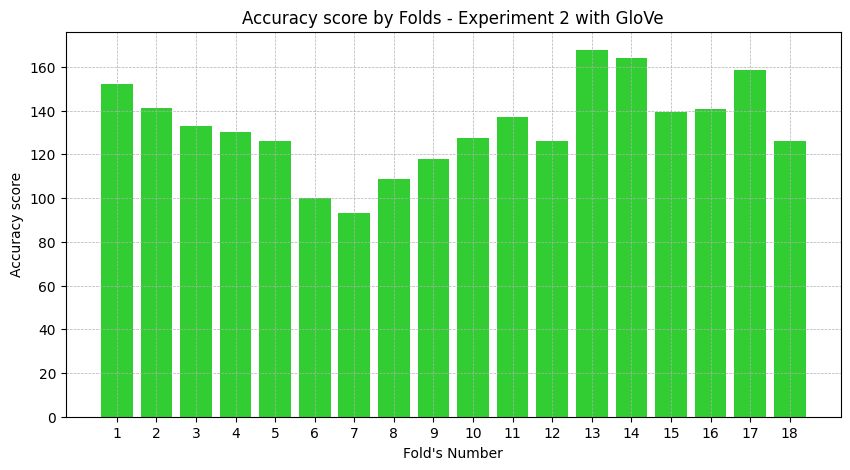

In [103]:
x = np.arange(1, k+1)
y = exp2_average_ranks

# Print mean and standard deviation
print("mean:")
print(round(statistics.mean(y), 3))
print("std:")
std = round(statistics.stdev(y), 3)
print(std)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.bar(x, y, color="limegreen")
plt.xlabel("Fold's Number")
plt.ylabel('Accuracy score')
plt.title('Accuracy score by Folds - Experiment 2 with GloVe')
plt.xticks(range(1, 19))
plt.grid(True, linestyle='dashed', linewidth=0.5)
plt.show()

#### Experiment 3

In [104]:
# Load Fmridata from EX3_dict
exp3_data = exp3_dict.get("Fmridata")

# Read vectors from file
exp3_vectors_file = "vectors_243sentences.GV42B300.average.txt"
exp3_vectors = read_matrix("/content/Structured Task (sentence decoding)/vectors_243sentences.GV42B300.average.txt", sep=" ")

# Read sentences from file
exp3_sentences_file = "/content/Structured Task (sentence decoding)/stimuli_243sentences.txt"
with open(exp3_sentences_file, "r") as exp3_sentences:
    exp3_concepts = np.asarray(exp3_sentences.readlines())

In [105]:
# Number of folds
k = 18

# Calculate the number of concepts per fold
concepts_per_fold = len(exp3_concepts) // k

# Splitting the data into training and test sets according to 18-fold cross-validation
exp3_average_ranks = []
start = 0
end = concepts_per_fold
for i in range(k):
    test_vectors = exp3_vectors[start:end]
    test_data = exp3_data[start:end]
    test_list = list(range(start, end))
    train_list = list(set(range(len(exp3_data))) - set(test_list))

    # Train the decoder using the provided code
    decoder3 = learn_decoder(exp3_data[train_list, :], exp3_vectors[train_list, :])

    start += concepts_per_fold
    end += concepts_per_fold

    # Use the decoder to decode semantic vectors
    prediction3 = np.dot(test_data, decoder3)

    # Evaluate the accuracy of these decoded vectors
    ranks = []
    for v, index in enumerate(test_list):
        ranks.append(calculate_rank(index, prediction3[v], exp3_vectors))

    exp3_average_ranks.append(np.mean(ranks))


mean:
100.021
std:
26.276


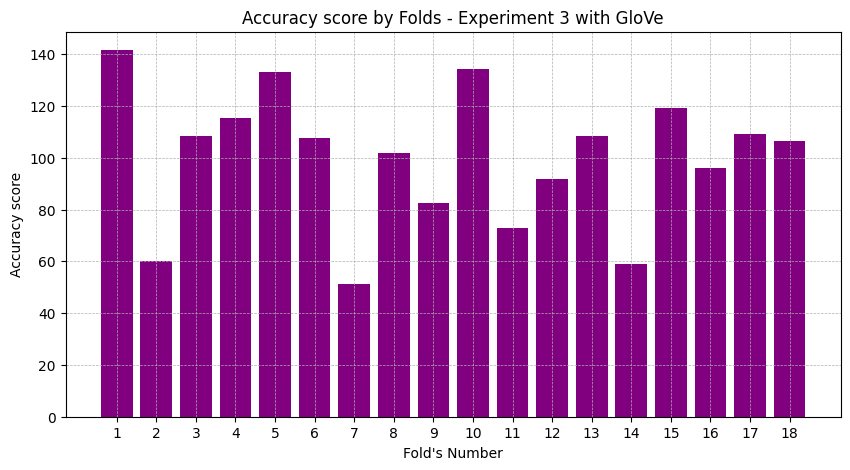

In [106]:
x = np.arange(1, k+1)
y = exp3_average_ranks

# Print mean and standard deviation
print("mean:")
print(round(statistics.mean(y), 3))
print("std:")
std = round(statistics.stdev(y), 3)
print(std)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.bar(x, y, color="purple")
plt.xlabel("Fold's Number")
plt.ylabel('Accuracy score')
plt.title('Accuracy score by Folds - Experiment 3 with GloVe')
plt.xticks(range(1, 19))
plt.grid(True, linestyle='dashed', linewidth=0.5)
plt.show()

#### Comparision between expirements 2 & 3

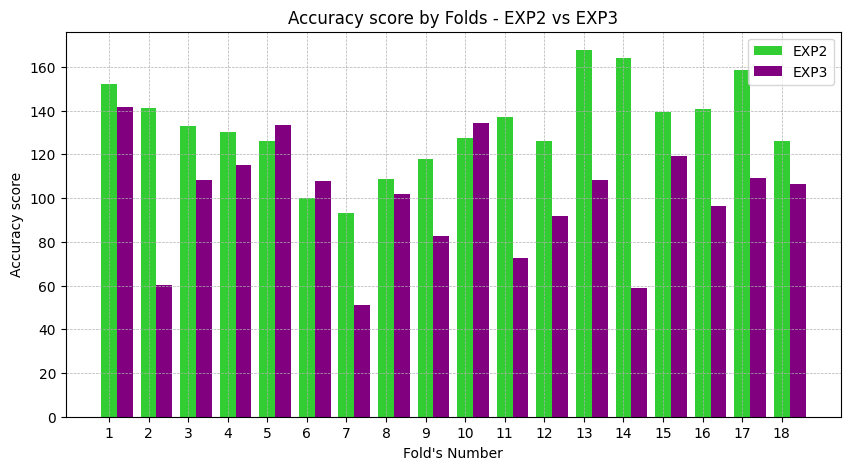

In [20]:
# Plotting comparison graph

# Data for the first bar graph
k = 18
x1 = range(1, k+1)
x = np.arange(1, k+1)

# Set the width of each bar
bar_width = 0.4

# Plotting the bar graphs
plt.figure(figsize=(10,5))
plt.bar(x1, exp2_average_ranks,color='limegreen', label='EXP2', width=bar_width)
plt.bar(x+ bar_width, exp3_average_ranks, color="purple", label='EXP3', width=bar_width)
plt.xlabel("Fold's Number")
plt.ylabel('Accuracy score')
plt.title('Accuracy score by Folds - EXP2 vs EXP3')
plt.xticks(range(1, k+1))
plt.grid(True, linestyle='dashed', linewidth = 0.5)
plt.legend(loc='upper right')

# Adjusting subplot spacing
plt.subplots_adjust(wspace=0.5)

# Display the combined plot
plt.show()

In [21]:
# Calculating mean and standard deviation
mean_1 = round(np.mean(exp2_average_ranks), 3)
std_1 = round(np.std(exp2_average_ranks), 3)
mean_2 = round(np.mean(exp3_average_ranks), 3)
std_2 = round(np.std(exp3_average_ranks), 3)

print(f"GloVe mean score on experiment 2 is: {mean_1}")
print(f"GloVe std score on experiment 2 is: {std_1}")
print()
print(f"GloVe mean score on experiment 3 is: {mean_2}")
print(f"GloVe std score on experiment 3 is: {std_2}")

GloVe mean score on experiment 2 is: 132.775
GloVe std score on experiment 2 is: 19.726

GloVe mean score on experiment 3 is: 100.021
GloVe std score on experiment 3 is: 25.535


In experiment 2, the average accuracy score was higher than in experiment 3, 132.775 > 100.021, indicating better overall performance. Moreover, the lower standard deviation in experiment 2 suggests that the accuracy scores were more consistent and less variable across the folds compared to experiment 3: 19.726 < 25.535.

#### Comparision between expirements 1 & 2 & 3

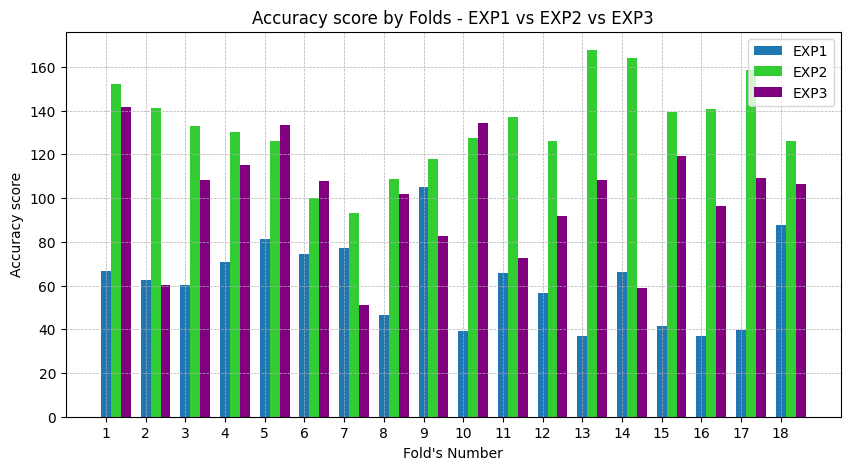

In [60]:
# Data for the bar graphs
k = 18
x = np.arange(1, k+1)

# Set the width of each bar
bar_width = 0.25

# Plotting the bar graphs
plt.figure(figsize=(10, 5))
plt.bar(x, average_ranks_HW3, label='EXP1', width=bar_width)
plt.bar(x + bar_width, exp2_average_ranks, color='limegreen', label='EXP2', width=bar_width)
plt.bar(x + 2 * bar_width, exp3_average_ranks, color='purple', label='EXP3', width=bar_width)

plt.xlabel("Fold's Number")
plt.ylabel('Accuracy score')
plt.title('Accuracy score by Folds - EXP1 vs EXP2 vs EXP3')
plt.xticks(range(1, k + 1))
plt.grid(True, linestyle='dashed', linewidth=0.5)
plt.legend(loc='upper right')

# Adjusting subplot spacing
plt.subplots_adjust(wspace=0.5)

# Display the combined plot
plt.show()


In [29]:
# Calculating mean and standard deviation
mean_1 = round(np.mean(average_ranks_HW3), 3)
std_1 = round(np.std(average_ranks_HW3), 3)
mean_2 = round(np.mean(exp2_average_ranks), 3)
std_2 = round(np.std(exp2_average_ranks), 3)
mean_3 = round(np.mean(exp3_average_ranks), 3)
std_3 = round(np.std(exp3_average_ranks), 3)

print(f"GloVe mean score on experiment 1 is: {mean_1}")
print(f"GloVe std score on experiment 1 is: {std_1}")
print()
print(f"GloVe mean score on experiment 2 is: {mean_2}")
print(f"GloVe std score on experiment 2 is: {std_2}")
print()
print(f"GloVe mean score on experiment 3 is: {mean_3}")
print(f"GloVe std score on experiment 3 is: {std_3}")

GloVe mean score on experiment 1 is: 61.911
GloVe std score on experiment 1 is: 18.786

GloVe mean score on experiment 2 is: 132.775
GloVe std score on experiment 2 is: 19.726

GloVe mean score on experiment 3 is: 100.021
GloVe std score on experiment 3 is: 25.535


These results are not surprising. The results from Experiment 1 indicate that it differs from Experiments 2 and 3 (combined) to a greater extent than the difference between Experiments 2 and 3. That's because we got lower accuracy score in experiment 1: 61.911 compared to higher results from experiments 2 and 3. This, in full accordance with part 2 in which we saw according to the article that experiment 1 differs to a higher degree from experiments 2 and 3 together than the level of difference between experiment 2 and 3.

### Part 4

Let's analyze the accuracy scores from part 3, and try to identify the topics where the decoder was more or less successful in predicting the sentences.

#### Experiment 2

In [199]:
res2 = np.dot(exp2_dict['Fmridata'], decoder2)
rank_results2 = []
vector_index = 0
total_rank = 0

for i, vec in enumerate(res2):
  sim_results = [(calculate_rank(vector_index, vec, exp2_vectors), j) for j in range(384)]
  sim_results.sort(key=lambda x: x[0], reverse=True)
  rank = next((x + 1 for x, y in enumerate(sim_results) if y[1] == vector_index), None)
  rank_results2.append((rank, vector_index))
  total_rank += rank
  vector_index += 1

topics_ids2 = [exp2_dict['labelsPassageCategory'][exp2_dict['labelsPassageForEachSentence'][i] - 1][0][0] for i in range(384)]
sentence_num2 = [x[1] for x in rank_results2]
rank2 = [x[0] for x in rank_results2]

In [200]:
import pandas as pd

df2 = pd.DataFrame({'sentence num': sentence_num2, 'Accuracy rank': rank2, 'Topic ID': topics_ids2})

In [201]:
topics_ranks2 = df2.groupby('Topic ID', as_index=False)['Accuracy rank'].mean()
topics_names2 = list(exp2_dict['keyPassageCategory'])
topics_names2 = [topics_names2[0][i][0] for i in range(len(topics_names2[0]))]
topics_ranks2['Topic Name'] = topics_names2
topics_ranks2 = topics_ranks2.sort_values(by=['Accuracy rank'])
topics_ranks2 = topics_ranks2.reset_index(drop=True)

In [228]:
sorted_topics_ranks2 = topics_ranks2[['Topic ID', 'Topic Name', 'Accuracy rank']].sort_values(by='Accuracy rank', ascending=False)
sorted_topics_ranks2 = sorted_topics_ranks2.reset_index(drop=True)
sorted_topics_ranks2


,Topic ID,Topic Name,Accuracy rank
0,21,tool,255.5
1,2,appliance,245.5
2,3,bird,244.5
3,5,building_part,244.5
4,9,drink_non_alcoholic,226.5
5,11,fish,225.5
6,6,clothing,221.5
7,19,place,214.5
8,14,human,200.5
9,22,vegetable,197.5


The 5 best topics are:

In [216]:
print(sorted_topics_ranks2['Topic Name'].head(5))

0                   tool
1              appliance
2                   bird
3          building_part
4    drink_non_alcoholic
Name: Topic Name, dtype: object


The 5 worst topics are:

In [217]:
print(sorted_topics_ranks2['Topic Name'].tail(5))

19       insect
20    body_part
21     dwelling
22        fruit
23    furniture
Name: Topic Name, dtype: object


In [221]:
mean_topics_ranks2 = sorted_topics_ranks2['Accuracy rank'].mean()
print(f"The mean accuracy score by topics is: {mean_topics_ranks2}")

median_topics_ranks2 = sorted_topics_ranks2['Accuracy rank'].median()
print(f"The median accuracy score by topics is: {median_topics_ranks2}")

The mean accuracy score by topics is: 192.5
The median accuracy score by topics is: 188.5


#### Experiment 3

In [206]:
res3 = np.dot(exp3_dict['Fmridata'], decoder3)
rank_results3 = []
vector_index = 0
total_rank = 0

for i, vec in enumerate(res3):
  sim_results = [(calculate_rank(vector_index, vec, exp3_vectors), j) for j in range(243)]
  sim_results.sort(key=lambda x: x[0], reverse=True)
  rank = next((x + 1 for x, y in enumerate(sim_results) if y[1] == vector_index), None)
  rank_results3.append((rank, vector_index))
  total_rank += rank
  vector_index += 1

topics_ids3 = [exp3_dict['labelsPassageCategory'][exp3_dict['labelsPassageForEachSentence'][i] - 1][0][0] for i in range(243)]
sentence_num3 = [x[1] for x in rank_results3]
rank3 = [x[0] for x in rank_results3]

In [207]:
df3 = pd.DataFrame({'sentence num': sentence_num3, 'Accuracy rank': rank3, 'Topic ID': topics_ids3})

In [208]:
topics_ranks3 = df3.groupby('Topic ID', as_index=False)['Accuracy rank'].mean()
topics_names3 = list(exp3_dict['keyPassageCategory'])
topics_names3 = [topics_names3[0][i][0] for i in range(len(topics_names3[0]))]
topics_ranks3['Topic Name'] = topics_names3
topics_ranks3 = topics_ranks3.sort_values(by=['Accuracy rank'])
topics_ranks3 = topics_ranks3.reset_index(drop=True)

In [229]:
sorted_topics_ranks3 = topics_ranks3[['Topic ID', 'Topic Name', 'Accuracy rank']].sort_values(by='Accuracy rank', ascending=False)
sorted_topics_ranks3 = sorted_topics_ranks3.reset_index(drop=True)
sorted_topics_ranks3

,Topic ID,Topic Name,Accuracy rank
0,21,skiing,238.5
1,20,rock_climbing,228.0
2,19,pyramid,217.5
3,5,castle,207.5
4,18,polar_bear,197.5
5,15,owl,187.5
6,16,painter,177.5
7,14,opera,167.0
8,11,infection,156.5
9,4,bone_fracture,146.0


The 5 best topics are:

In [225]:
print(sorted_topics_ranks3['Topic Name'].head(5))

0           skiing
1    rock_climbing
2          pyramid
3           castle
4       polar_bear
Name: Topic Name, dtype: object


The 5 best worst are:

In [226]:
print(sorted_topics_ranks3['Topic Name'].tail(5))

19     ice_cream
20     hurricane
21      gambling
22        dreams
23    beekeeping
Name: Topic Name, dtype: object


In [227]:
mean_topics_ranks3 = sorted_topics_ranks3['Accuracy rank'].mean()
print(f"The mean accuracy score by topics is: {mean_topics_ranks3}")

median_topics_ranks3 = sorted_topics_ranks3['Accuracy rank'].median()
print(f"The median accuracy score by topics is: {median_topics_ranks3}")

The mean accuracy score by topics is: 121.8125
The median accuracy score by topics is: 121.5
